# Basic usage of the cosmoDC2 catalog and photoz add-on catalog - Weak gravitational lensing shear by dark matter halo

Author : Constantin Payerne

**This notebook can be run at NERSC or CC-IN2P3, where the DESC DC2 products are stored. You need to be a DESC member to be able to access those.**

This notebook shows how to use the cosmoDC2 catalog and the photometric redshift (photo-z) add-on catalog to estimate the average excess surface density around galaxy clusters (i.e. to produce the data vector needed for WL mass estimation).

After going through this notebook, you should be able to:

- extract a dark matter halo catalog from cosmoDC2,
- load the background galaxy catalog from cosmoDC2 (around a given halo),
- access the photo-z of background galaxies from the photoz add-on catalog,
- compute the excess surface density estimator using the above.

Along with standard packages, you need to have the [CLMM](https://github.com/LSSTDESC/CLMM) library installed to run this notebook.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.integrate
from astropy.table import Table, join
import healpy

In [2]:
import clmm 
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site('in2p3')

NB: A detailled GitHub repository with multiple example the use of GCRCatalogs is available at https://github.com/LSSTDESC/DC2-analysis/tree/master/tutorials.

# 1. Identify a cluster (massive dark matter halo) in cosmoDC2

Here, we load the cosmoDC2 exctragalactic catalog (small version)

In [3]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In order to speed up the extraction of cosmoDC2 data, we select a dark matter halo within a specified healpix pixel available in `cosmoDC2_v1.1.4_small`. The user can change the selected healpix pixel by modifying the quantity `index_healpix_pixels_selected` below.

In [4]:
healpix_pixels = extragalactic_cat.get_catalog_info()['healpix_pixels']
print(healpix_pixels)

[9559, 9686, 9687, 9814, 9815, 9816, 9942, 9943, 10070, 10071, 10072, 10198, 10199, 10200, 10326, 10327, 10450]


In [5]:
index_healpix_pixels_selected = 6

In [6]:
healpix_selected = healpix_pixels[index_healpix_pixels_selected]
print('The selected healpix pixel is ' + str(healpix_selected))

The selected healpix pixel is 9942


We extract the dark matter halo catalog for this specified healpix pixel by
- asking that the cosmoDC2 galaxy is a central galaxy (of a halo), with the flag `is_central=True`. 
- applying some property cut (here, mass and redshift range). 

In [7]:
# get list of massive halos in a given redshift and mass range

mmin = 1.1*1.e14 # Msun
zmin = 0.2
zmax = 0.9
massive_halos = extragalactic_cat.get_quantities(['halo_mass','redshift','ra', 'dec', 'halo_id'],
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', 
                                                          f'redshift<{zmax}'
                                                         ], native_filters=['healpix_pixel == ' + str(healpix_selected)])
N_halo = len(massive_halos['halo_mass'])

print(f'There are {N_halo} clusters in this mass and redshift range, in this healpix pixel')

There are 35 clusters in this mass and redshift range, in this healpix pixel


In [8]:
massive_halos['halo_mass']

array([1.62517701e+14, 2.45585715e+14, 1.99243027e+14, 2.93007107e+14,
       1.29275420e+14, 1.36834147e+14, 1.13029876e+14, 1.15746131e+14,
       2.05034239e+14, 7.12337103e+14, 1.18711918e+14, 1.21552938e+14,
       1.71149933e+14, 1.18639138e+14, 1.21368389e+14, 1.77622158e+14,
       1.16876821e+14, 1.17017183e+14, 1.27861408e+14, 1.32386767e+14,
       2.63297256e+14, 1.28521627e+14, 1.69722925e+14, 2.38416881e+14,
       1.43748250e+14, 2.85126068e+14, 1.50386829e+14, 4.75237942e+14,
       1.34531178e+14, 1.23772730e+14, 1.19182389e+14, 1.63617200e+14,
       2.35071599e+14, 1.23577783e+14, 4.70450056e+14])

We then select the most massive halo in the recovered sample.

In [9]:
select = massive_halos['halo_mass'] == np.min(massive_halos['halo_mass'])
ra_halo = massive_halos['ra'][select][0]
dec_halo = massive_halos['dec'][select][0]
z_halo = massive_halos['redshift'][select][0]
mass_halo =massive_halos['halo_mass'][select][0]
id_halo = massive_halos['halo_id'][select][0]

In [10]:
print (f'The most massive cluster has ID {id_halo}')
print(f'the halo is in ra = {ra_halo:.2f} deg, dec = {dec_halo:.2f} deg, with redshift = {z_halo:.2f} and mass = {mass_halo:.2e} Msun')

The most massive cluster has ID 10800142355
the halo is in ra = 63.32 deg, dec = -37.76 deg, with redshift = 0.37 and mass = 1.13e+14 Msun


# 2. Extract the galaxy catalog

The galaxy shapes and true redshifts are available in the cosmoDC2 extragalaxtic catalog, and their photometric redshifts (measured using the BPZ or FlexZboost codes) are available in separate add-on catalog. 
- We first extract the galaxies within an aperture of 0.6 degrees arround the cluster position, and with magnitude cut `mag_i < 25`.
- Then move to the add-on catalog to get the corresponding photoz.

## 2.1 Select galaxies in the cluster field
NB: at this stage, we load all galaxies in the field. Background galaxy selection will come in section 4.

In [11]:
# Position and magnitude cuts
ra_min, ra_max = ra_halo - 0.4, ra_halo + 0.4
dec_min, dec_max = dec_halo - 0.4, dec_halo + 0.4
mag_i_max = 24.25
mag_r_max = 28

We indentify the contiguous healix pixels corresponding to the window using the `healpy` package.

In [12]:
n_random = 100000
ra_random = np.random.random(n_random)*(ra_max-ra_min) + ra_min
dec_random = np.random.random(n_random)*(dec_max-dec_min) + dec_min
unique_healpix_in_window = list(np.unique(healpy.ang2pix(32, ra_random, dec_random, nest=False, lonlat=True)))
print('The selected contiguou healpix pixels within the window are ' + str(unique_healpix_in_window))

The selected contiguou healpix pixels within the window are [9814, 9815, 9942]


Extract the needed quantities for each galaxy:
- complex shear components `'shear_1'`, `'shear_2'`
- intrinsic ellipticity components `'ellipticity_1_true'`, `'ellipticity_2_true'`
- convergence `'convergence'`
- `ra`, `dec`, `redshift`

In [13]:
coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= 0']
mag_filters = ['mag_i < {}'.format(mag_i_max),'mag_r < {}'.format(mag_r_max),]
extragalactic_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image", config_overwrite=dict(healpix_pixels=unique_healpix_in_window))

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 
                                            'ra', 'dec',
                                            'shear_1', 'shear_2', 
                                            'ellipticity_1_true', 'ellipticity_2_true',
                                            'redshift', 'convergence', 'halo_id'],
                                            filters=(coord_filters + z_filters + mag_filters), 
                                          )

print(str(len(gal_cat['galaxy_id'])) +' loaded galaxies')

41819 loaded galaxies


## 2.2 Member galaxy identification for the selected cluster

From the galaxy catalog `gal_cat` (that contains all galaxies in the field, independent of redshift), the galaxies belonging to the dark matter halo (cluster) can be identified from the `halo_id` field.

In [14]:
member_gal_catalog = Table(gal_cat)[gal_cat['halo_id'] == id_halo]
print(f"There are {len(member_gal_catalog)} member galaxies in that halo")

There are 44 member galaxies in that halo


# 3. Extract photoz information

The full details of the photo-z add-on catalog `'cosmoDC2_v1.1.4_small_with_photozs_v1'` are given in the [photoz catalog notebook](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/extragalactic_gcr_photoz_catalogs.ipynb). This catalog contains photometric redshifts that were computed with the [BPZ template-based code](https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) and is the one we use. Note that the catalog `'cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1'` contains photozs from [FleXZBoost machine learning code](https://arxiv.org/abs/2001.03621) and could be used instead.

## 3.1 Load photoz quantities for each galaxy
The quantities of interest are
- the probability density function `'photoz_pdf'`,
- the mean photometric redshift `'photoz_mean'`.

NB: The add-on catalog does not support geometrical cut (in `ra`, `dec`, `redshift`). We first extract the photo-z informations in the corresponding healpix pixel, we then match with the cosmoDC2 galaxy sample.



In [15]:
# Load the photoz catalog
extragalactic_photoz_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')
z_bins = extragalactic_photoz_cat.photoz_pdf_bin_centers

In [16]:
# Get the redshift information
photoz_cat = extragalactic_photoz_cat.get_quantities(['photoz_pdf','photoz_mean','redshift', 'galaxy_id', 'photoz_odds'], 
                                                     native_filters=[(lambda p: np.isin(p, [unique_healpix_in_window]), "healpix_pixel")])

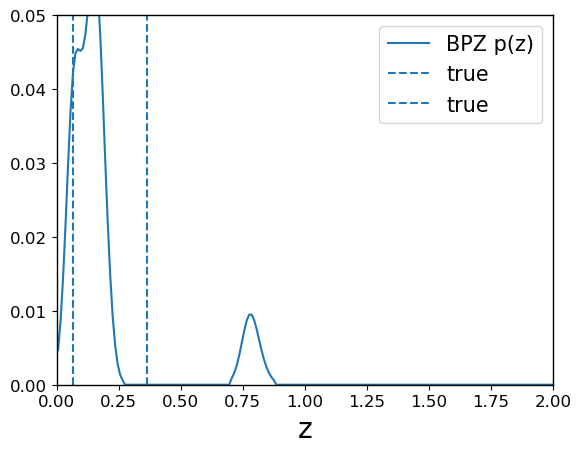

In [17]:
index = 1007

plt.rcParams['axes.linewidth'] = 1
plt.tick_params(axis='both', which = 'both', labelsize= 12)
plt.plot(z_bins, photoz_cat['photoz_pdf'][index], label = 'BPZ p(z)')
plt.vlines(photoz_cat['redshift'][index], 0, 1, ls = '--', label = 'true')
plt.vlines(photoz_cat['photoz_mean'][index], 0, 1, ls = '--', label = 'true')
plt.ylim(0, .05)
plt.xlim(0, 2)
plt.xlabel('z', fontsize = 20)
plt.legend(fontsize = 15)

In [18]:
len(photoz_cat['redshift'])

51714020

In [19]:
len(photoz_cat['galaxy_id'])

4797285

In [20]:
len(photoz_cat['galaxy_id'])

4797285

In [21]:
# Convert to astropy table
photoz_cat_astropy = Table()
#photoz_cat_astropy['redshift'] = photoz_cat['redshift']
photoz_cat_astropy['galaxy_id'] = photoz_cat['galaxy_id']
photoz_cat_astropy['photoz_pdf'] =  photoz_cat['photoz_pdf']
photoz_cat_astropy['photoz_mean'] =  photoz_cat['photoz_mean']
photoz_cat_astropy['photoz_odds'] =  photoz_cat['photoz_odds']

In [22]:
# Match the galaxy catalog and photoz catalog (using `galaxy_id`) and store in a new astropy table `cat_complete`
cat_complete = join(photoz_cat_astropy, gal_cat, keys = 'galaxy_id')

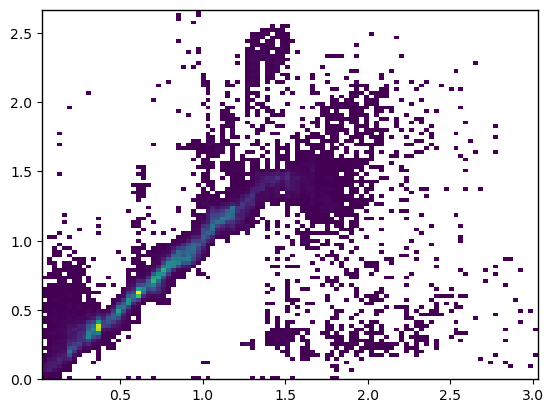

In [23]:
c=plt.hist2d(cat_complete['redshift'], cat_complete['photoz_mean'],cmin=1, bins=100)

## 3.2 Add derived photoz information to the table

For each galaxy, we calculate the probability of being in the background of the cluster, i.e. of having a redshift $>z_{\rm halo} + \delta$, where delta is a positive value (in this notebook, we choose $\delta = 0.$, which can be different for other analysis, depending on uncertaintiy on cluster redshift).

$$p_i = \int_{z_{\rm halo} + \delta}^{+\infty} dz\ p_{\rm photoz, i}(z)$$ where $p_{\rm photoz, i}$ is the photometric redshift probability density function for the galaxy $i$.

In [24]:
delta = 0.
z_min = z_halo + delta

In [25]:
axis_select_background = [0 if z_bins[i] < z_min else 1 for i in range(len(z_bins))]

In [26]:
m = np.zeros([len(cat_complete), len(z_bins)])
for i in range(len(cat_complete)):
    m[i,:] = np.array(cat_complete['photoz_pdf'][i])

In [27]:
integral_pdf_behind = scipy.integrate.simps(m * axis_select_background, x = z_bins, axis = 1)
norm_pdf = scipy.integrate.simps(m, x = z_bins, axis = 1)

In [28]:
# add the probability to be a background galaxy and the normalisation of the photoz pdf to the table.
cat_complete['background_probability'] = integral_pdf_behind / norm_pdf
cat_complete['photoz_pdf_norm'] = norm_pdf

# 4. Background source selection and contamination estimation

We discuss briefly the effect of redhsift selection of background galaxies, that is affected by the contamination of 'fake' background galaxies i.e. galaxies with true redshift below the halo redshift, but identified as background redshift due to specific cut on photometric information. In the same way, member galaxies can be identified as background galaxies. To test 2 different selection cuts, we consider 3 different cases:
- `cat_true`: cut on true galaxy redshift $z_{\rm cosmoDC2} > z_{\rm l} + \delta$ (identifying true background galaxies).
- `cat_photoz`: cut on mean photoz galaxy redshift $\langle z \rangle_{\rm photoz} > z_{\rm l} + \delta$,
- `cat_probability`: cut on background probability $\int_{z_{\rm halo} + \delta}^{+\infty} dz\ p_{\rm photoz, i}(z)  > 0.9$.

In [29]:
cat_true = cat_complete[cat_complete['redshift'] > z_min]
cat_photoz = cat_complete[cat_complete['photoz_mean'] > z_min]
cat_probability = cat_complete[cat_complete['background_probability'] > 0.9]

We can plot the background probability as a function of true redshift. We see that the majority of 'true' background galaxies are well labelled as observed background galaxies. However, we see that few galaxies have non-zero probability to be in the foreground of the cluster.

(0.0, 3.0)

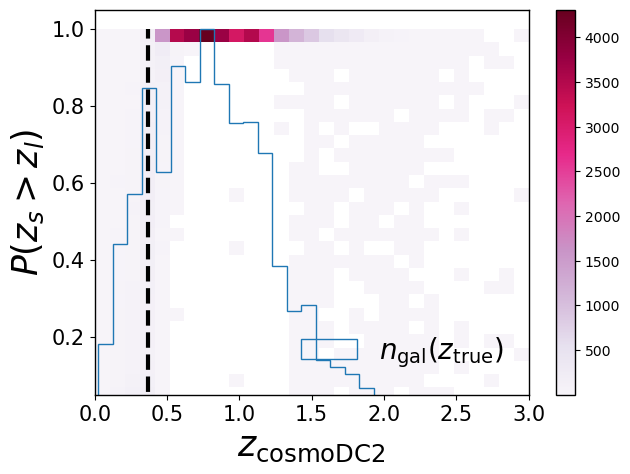

In [30]:
fig, ax = plt.subplots(1,1, figsize = (7,5))
plt.hist2d(cat_complete['redshift'] ,cat_complete['background_probability'], cmin = 1, bins = [np.linspace(0,3,30), np.linspace(0,1,30)], cmap = 'PuRd')
plt.hist(cat_complete['redshift'], density = True, histtype = 'step', bins = 30, label = r'$n_{\rm gal}(z_{\rm true})$')
plt.colorbar()
plt.vlines(z_halo, 0, 1, color = 'k', linestyle = '--', zorder = 1000, linewidth = 3)
plt.ylabel(r'$P(z_s > z_l)$', fontsize = 25)
plt.xlabel(r'$z_{\rm cosmoDC2}$', fontsize = 25)
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.legend(fontsize = 20, loc = 'lower right', frameon = False, framealpha = 1)
plt.ylim(0.05,1.05)
plt.xlim(0,3)

We check the contamination of member galaxies by counting the member galaxies and also the foreground galaxies in each dataset:

In [31]:
# catalog of member galaxies containing all photoz information
member_gal_photoz_catalog = cat_complete[np.isin(cat_complete['galaxy_id'],member_gal_catalog['galaxy_id'])]

In [32]:
pdf_member_galaxy_average = 0
for i, pdf in enumerate(member_gal_photoz_catalog['photoz_pdf']):
    pdf_member_galaxy_average = pdf_member_galaxy_average + pdf/member_gal_photoz_catalog['photoz_pdf_norm'][i]

We note that the combination of the redshift cut based on the mean photometric redshift and the odds cut has reduced the proportion of foreground galaxies, but has significantly reduced the size of the sample. 

# 5. Compute the excess surface density profile of the cluster

### Estimator of the excess surface density

- The maximum likelihood estimator of the excess surface density in the radial bin $[R, R + \Delta R[$ is defined by

$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{s = 1} w_{s}}
     \sum\limits_{s= 1}w_{s}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s},$$ where $\epsilon_+^{s}$ is the tangential ellipticity of the background galaxy with index $s$ (as source) relative to the dark matter halo position with index $l$ (as lens).
     
- The critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$, where $D_A(z_l), D_A(z_s)$ are respectively the angular diameter distance to the lens and to the source in physical units, and $D_A(z_s, z_l)$ is the angular diameter distance between the lens and the source.


- The average $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle$ is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + \delta}^{+\infty} d z_s\ p_{\rm photoz,s}(z_s)\ \Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p_{\rm photoz,s}$ is the photometric probability density function for the background galaxy with index $s$.

### Weights $w_s$

The quantities $w_{s}$ are the weights that maximise the sigmnal-to-noise ratio of the excess surface density estimator. They downweight the galaxies that are close in redshift to the cluster (where the lensing signal is weak). They include the lack of informations on both redshift and shape reconstruction for each background galaxies. 

- In the case where there is no error on the shape measurement (for the purpose of cosmoDC2 galaxies), the weight writes $w_{s} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,

- In the case of true redshift $z_s$, the PDF reduces to a Dirac function centered at $z_s$, giving the average $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and the weight $w_{s} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,


In [33]:
# Define a CLMM cosmology object; used to compute the critical surface density
cosmo = clmm.Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [34]:
# Inverse critical surface density. Recall that z_bins are the bin centers of the photoz pdf.
sigma_crit_1 = np.array(1/cosmo.eval_sigma_crit(z_halo, z_bins))

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


In [35]:
m = np.zeros([len(cat_complete), len(z_bins)])
for i in range(len(cat_complete)):
    m[i,:] = np.array(cat_complete['photoz_pdf'][i])

In [36]:
# compute the average inverse critical surface density
unormed_integral = scipy.integrate.simps(m * sigma_crit_1, x = z_bins, axis = 1)
norm = scipy.integrate.simps(m, x = z_bins, axis = 1)

**We compute the excess surface density in 3 different cases:**

- using true backgroud galaxy redshift : $w_{ls}^{\rm true} = \Sigma_{\rm crit}(z_{\rm cosmoDC2},z_l)^{-2}$
- using photometric probability density function : $w_{ls}^{\rm pdf} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$
- using mean photometric redshift $w_{ls}^{\rm mean} = \Sigma_{\rm crit}(\langle z \rangle_{\rm photoz},z_l)^{-2}$ 
- using random sample redshift from the photoz pdf : $w_{ls}^{\rm mean} = \Sigma_{\rm crit}( z_{\rm random},z_l)^{-2}$

In [37]:
# define the various weights, depending of the case considered
ws_pdf = (unormed_integral/norm)**2
ws_true = ( 1. /cosmo.eval_sigma_crit(z_halo, cat_complete['redshift']) )**2 
ws_mean = ( 1. /cosmo.eval_sigma_crit(z_halo, cat_complete['photoz_mean']) )**2 

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


In [38]:
import warnings
warnings.filterwarnings('ignore')
ws_random = []
for pdf in cat_complete['photoz_pdf']:
    ws_random.append(np.random.choice(1./cosmo.eval_sigma_crit(z_halo, z_bins), p = pdf/np.sum(pdf))**2) 
ws_random = np.array(ws_random)

For the thee cases using photoz, the weights $p_s$ scatter arround the black curves below $z \approx 1.5$, beyond this redshift, the occurences of catastrophic photometric redshift reconstruction increases and the deviation to the black lines is larger. Additive quality cut cat be applied to remove catastrophic redshift reconstruction from the data set

In [39]:
cat_complete['ws_true'] = np.array(ws_true)
cat_complete['ws_pdf'] = np.array(ws_pdf)
cat_complete['ws_mean'] = np.array(ws_mean)
cat_complete['ws_random'] = np.array(ws_random)

In [40]:
data_complete = clmm.GCData(cat_complete)
cl_complete = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_complete)

We compute the tangential ellipticity for each background galaxy relative to the dark matter halo center (we use the `CLMM` package)

In [41]:
cl_complete.compute_tangential_and_cross_components(
                                    shape_component1='ellipticity_1_true', shape_component2='ellipticity_2_true', 
                                    tan_component='shear_t', cross_component='shear_x',
                                    geometry="flat")

# add projected radial distance of the galaxy to the cluster center to the table
cl_complete.galcat['r'] = cosmo.eval_da(cl_complete.z)*cl_complete.galcat['theta']

We create a galaxy catalog `cl_true` with background selection on the true redshift. This is the ideal situation where there is no mis-identification of background gaalxies.

In [42]:
data_true = clmm.GCData(cl_complete.galcat[cl_complete.galcat['redshift'] > z_min])
cl_true = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_true)

#### To compute the excess surface density,

- We define a set of bin edges,

- We compute the average excess surface density in each bins as described above,

- We compute the errorbars as the standard deviation in each bin.

In [43]:
bin_edges = clmm.make_bins(.1,  3, nbins=10, method='evenlog10width')
radial_bins = [[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges)-1)]

In [44]:
def make_radial_profile(catalog, radial_bins, radius='r', tangential_component='shear_t', weight = 'ws_true'):
    '''
    Evaluates the contamination from member galaxies and foreground galaxies
    in each radial bin of the profile
    
    Parameters:
    -----------
        catalog: CLMM galaxy cluster object
            Contains the galcat table
        radial_bin: array-like
            Radial binning of the profile
        radius: str
            Name of the radius column in the galcat table
        tangential_component: str
            Name of the tangential shear component column in the galcat table
        weights: str
            Name of the weights column in the galcat table
                
    Returns:
    --------
        profile: astropy table
            Excess surface density profile and corresponding errors
    ''' 

    profile = Table(names=['r', 'DS', 'DS_err'])
    
    for i, r_bin in enumerate(radial_bins):     
        mask = (catalog.galcat[radius] > r_bin[0])*(catalog.galcat[radius] <= r_bin[1])*(catalog.galcat[weight] != 0)
        data_cut = catalog.galcat[mask]
        
        if len(data_cut) == 0:          
            profile.add_row([r_mean, None, None])
            continue
        
        r_mean = np.mean(data_cut['r'])
        ds = np.average(data_cut[tangential_component]*data_cut[weight]**(-0.5), 
                             weights = data_cut[weight])
        
        # Standard deviation of the excess surface density        
        ds_rms = np.sqrt(np.average((data_cut[tangential_component]*data_cut[weight]**(-0.5) - ds)**2, 
                                         weights = data_cut[weight]))/np.sqrt(len(data_cut))

        profile.add_row([r_mean, ds, ds_rms])
        
    return profile

## Contamination effect

We create two CLMM galaxy cluster objects, based on the 2 different background galaxy selection criteria:
- `cl_photoz_mean` with cut :  $\langle z \rangle > z_{\rm halo} + \delta$
- `cl_photoz_prob` with cut : $P(z > z_{\rm halo} + \delta)  > 0.9$

In [45]:
data_photoz_mean = clmm.GCData(cl_complete.galcat[cl_complete.galcat['photoz_mean'] > z_min + 0.2])
cl_photoz_mean = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_photoz_mean)

In [46]:
data_photoz_prob = clmm.GCData(cl_complete.galcat[cl_complete.galcat['background_probability'] > 0.8])
cl_photoz_prob = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_photoz_prob)

In [47]:
data_photoz_mean_and_prob = clmm.GCData(cl_complete.galcat[(cl_complete.galcat['background_probability'] > 0.8)&(cl_complete.galcat['photoz_mean'] > z_min + 0.2)])
cl_photoz_mean_and_prob = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_photoz_mean_and_prob)

In [48]:
def contamination_profile(catalog, radial_bin, radius='r'):
    '''
    Evaluates the contamination from member galaxies and foreground galaxies
    in each radial bin of the profile
    
    Parameters:
    -----------
        catalog: CLMM galaxy cluster object
            Contains the galcat table
        radius: str
            Name of the radius column in the galcat table
        radial_bin: array-like
            Radial binning of the profile
            
    Returns:
    --------
        profile: astropy table
            Contamination profile
    ''' 

    profile = Table(names=['r', 'count_foreground', 'count_member'])
    
    for i, r_bin in enumerate(radial_bin):       
        mask_foreground = (catalog.galcat['redshift'] < z_halo)
        mask_radius = (catalog.galcat[radius] > r_bin[0])*(catalog.galcat[radius] <= r_bin[1])
        data_cut = catalog.galcat[mask_radius]
        if len(data_cut) == 0:            
            continue
        r_mean = np.mean(data_cut['r'])      
        data_cut_foreground = catalog.galcat[mask_radius * mask_foreground]
        data_member = catalog.galcat['galaxy_id'][mask_radius][np.isin(catalog.galcat['galaxy_id'][mask_radius],member_gal_catalog['galaxy_id'])]
        profile.add_row([r_mean, len(data_cut_foreground)/len(data_cut), len(data_member)/len(data_cut)])
    return profile

We check the contamination of member galaxies and foreground galaxies in each dataset

In [49]:
bin_centers = np.mean(radial_bins, axis = 1)

contamination_photoz_mean = contamination_profile(cl_photoz_mean, radial_bins, radius = 'r')
contamination_photoz_prob = contamination_profile(cl_photoz_prob, radial_bins, radius = 'r')
contamination_photoz_mean_and_prob = contamination_profile(cl_photoz_mean_and_prob, radial_bins, radius = 'r')

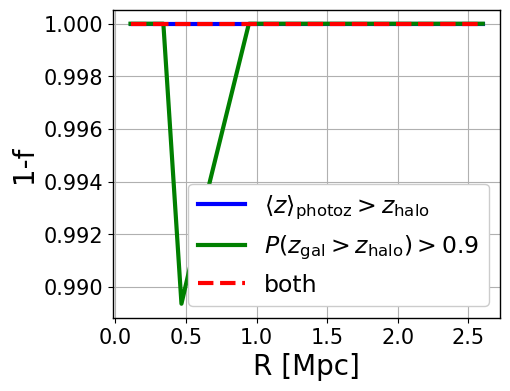

In [50]:
plt.figure(figsize = (5,4))
plt.tick_params(axis='both', which = 'both', labelsize= 15)
plt.plot(contamination_photoz_mean['r'], 1-contamination_photoz_mean['count_member'],\
         '-b', label = r'$\langle z \rangle_{\rm photoz} > z_{\rm halo}$', linewidth = 3)
plt.plot(contamination_photoz_prob['r'], 1-contamination_photoz_prob['count_member'],'-g', \
         label = r'$P(z_{\rm gal} > z_{\rm halo})  > 0.9$', linewidth = 3)
plt.plot(contamination_photoz_prob['r'], 1-contamination_photoz_mean_and_prob['count_member'],'--r', \
         label = r'both', linewidth = 3)
plt.xlabel('R [Mpc]', fontsize = 20)
plt.grid(True, which='both')
plt.ylabel(f'1-f', fontsize = 20)
plt.legend(frameon = True, framealpha = 1, fontsize = 17, loc = 'best')